## Code modules, functions, & links
[Generate Artificial Faces with CelebA Progressive GAN Model](https://github.com/tensorflow/hub/blob/master/examples/colab/tf_hub_generative_image_module.ipynb)

In [1]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-x7qycgfk
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-x7qycgfk
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0cc14a8a40d1bddf8f3b04c908c94d69e9d8addce_-py3-none-any.whl size=113998 sha256=4a7c53da21019ac316c3f2a03154631dacb43a8166ea5f8a6d6c2a63ebd78f15
  Stored in directory: /tmp/pip-ephem-wheel-cache-4iktkq8i/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np,pylab as pl,pandas as pd
import imageio,h5py
import tensorflow as tf
tf.random.set_seed(23)
from tensorflow_docs.vis import embed
import tensorflow_hub as th

In [3]:
def timg(img):
    img=tf.constant(img)
    img=tf.image.convert_image_dtype(img,tf.uint8)
    pl.imshow(img.numpy()); pl.title(img.shape);
def tanimate(images):
    converted_images=np.clip(images*255,0,255)\
    .astype(np.uint8)
    imageio.mimsave('animation.gif',converted_images)
    return embed.embed_file('animation.gif')

## Symbol images & hypersphere interpolation

In [4]:
fpath='../input/classification-of-handwritten-letters/'
f='LetterColorImages_123.h5'
f=h5py.File(fpath+f,'r')
keys=list(f.keys()); print(keys)
x=np.array(f[keys[1]],dtype='float32')/255
x=np.array(tf.image.resize(x,[128,128]),dtype='float32')
y=np.array(f[keys[2]],dtype='int32')\
.reshape(-1,1)-1
N=len(y); n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(23).shuffle(shuffle_ids)
x,y=x[shuffle_ids],y[shuffle_ids]
x.shape,y.shape

['backgrounds', 'images', 'labels']


((14190, 128, 128, 3), (14190, 1))

In [5]:
def interpolate_hypersphere(v1,v2,steps):
    v1norm=tf.norm(v1)
    v2norm=tf.norm(v2)
    v2normalized=v2*(v1norm/v2norm)
    vectors=[]
    for step in range(steps):
        interpolated=v1+(v2normalized-v1)*step/(steps-1)
        interpolated_norm=tf.norm(interpolated)
        interpolated_normalized=\
        interpolated*(v1norm/interpolated_norm)
        vectors.append(interpolated_normalized)
    return tf.stack(vectors)


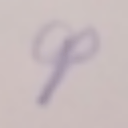

In [6]:
imgs=interpolate_hypersphere(x[7],x[8],120)
tanimate(imgs)

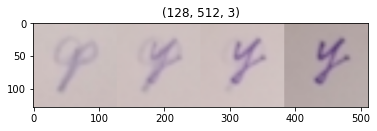

In [7]:
timg(np.concatenate([x[7],imgs[40],
                     imgs[80],x[8]],axis=1))

## Latent space interpolation using a pre-trained Progressive GAN

In [8]:
handle='https://tfhub.dev/google/progan-128/1'
progan=th.load(handle).signatures['default']
latent_dim=512

In [9]:
def interpolate_between_vectors(steps,latent_dim=512):
    tf.random.set_seed(1)
    v1=tf.random.normal([latent_dim])
    v2=tf.random.normal([latent_dim])
    vectors=interpolate_hypersphere(v1,v2,steps)
    interpolated_images=progan(vectors)['default']
    return interpolated_images


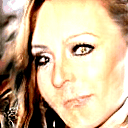

In [10]:
imgs2=interpolate_between_vectors(30)
tanimate(imgs2)

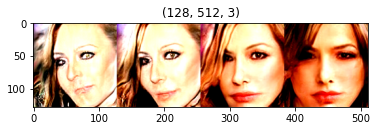

In [11]:
timg(np.concatenate([imgs2[0],imgs2[10],
                     imgs2[-10],imgs2[-1]],axis=1))

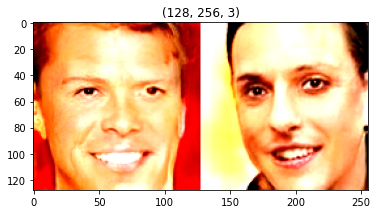

In [12]:
tf.random.set_seed(23)
initial_vector=tf.random.normal([1,latent_dim])
initial_img=progan(initial_vector)['default'][0]
tf.random.set_seed(123)
target_vector=tf.random.normal([1,latent_dim])
target_img=progan(target_vector)['default'][0]
timg(np.concatenate([initial_img,target_img],axis=1))

In [13]:
def find_closest_latent_vector(initial_vector,target_img,
                               steps,steps_per_image):
    images=[]; losses=[]
    vector=tf.Variable(initial_vector)  
    optimizer=tf.optimizers.Adam(learning_rate=.01)
    loss_fn=tf.losses.MeanAbsoluteError(reduction="sum")
    for step in range(steps):
        if (step%100)==0: print()
        print('.',end='')
        with tf.GradientTape() as tape:
            image=progan(vector.read_value())['default'][0]
            if (step%steps_per_image)==0:
                images.append(image.numpy())
            target_image_difference=loss_fn(image,target_img[:,:,:3])
            regularizer=tf.abs(tf.norm(vector)-np.sqrt(latent_dim))     
            loss=target_image_difference+regularizer
            losses.append(loss.numpy())
        grads=tape.gradient(loss,[vector])
        optimizer.apply_gradients(zip(grads,[vector]))
    return images,losses
steps=200; steps_per_image=5
images,loss=find_closest_latent_vector(initial_vector,target_img,
                                       steps,steps_per_image)


....................................................................................................
....................................................................................................


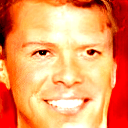

In [14]:
tanimate(np.stack(images))

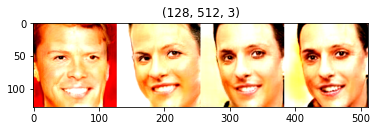

In [15]:
timg(np.concatenate([images[0],images[10],
                     images[-10],target_img],axis=1))